In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dense, Flatten, Input, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import sys
sys.path.append('./')

In [28]:
class ResBlock(tf.keras.layers.Layer):

    def __init__(self, filters, kernel_size, **kwargs):
        self.filters = filters
        self.kernel_size = kernel_size
        super(ResBlock, self).__init__(**kwargs)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size,
        })
        return config


    def build(self, input_shape):
        self.conv2d_w1 = self.add_weight("conv2d_w1", self.kernel_size + (self.filters, self.filters), initializer='glorot_uniform')
        self.conv2d_w2 = self.add_weight("conv2d_w2", self.kernel_size + (self.filters, self.filters), initializer='glorot_uniform')

        self.conv2d_b1 = self.add_weight("conv2d_b1", (self.filters,), initializer='zero')
        self.conv2d_b2 = self.add_weight("conv2d_b2", (self.filters,), initializer='zero')
        super(ResBlock, self).build(input_shape)

    def call(self, x):
        y = K.conv2d(x, self.conv2d_w1, padding="same")
        y = K.bias_add(y, self.conv2d_b1)
        y = K.relu(y)

        y = K.conv2d(y, self.conv2d_w2, padding="same")
        y = K.bias_add(y, self.conv2d_b2)
        y = K.relu(y)
        y = y+x

        return y

    def compute_output_shape(self, input_shape):
        return input_shape

In [29]:
def drcnn(input_shape, num_classes):
    x = Input(input_shape)
    y = Conv2D(32, (3,3), activation='relu')(x)
    y = BatchNormalization(axis=-1)(y)
    y = MaxPooling2D((2,2))(y)
    y = Dropout(0.1)(y)

    y = Conv2D(64, (3,3), activation='relu')(y)
    y = BatchNormalization(axis=-1)(y)
    y = Conv2D(64, (3,3), activation='relu')(y)
    y = BatchNormalization(axis=-1)(y)
    y = MaxPooling2D((2,2))(y)
    y = Dropout(0.1)(y)

    y = ResBlock(64, (3,3))(y)
    y = BatchNormalization(axis=-1)(y)
    y = Flatten()(y)
    y = Dense(256, activation='relu')(y)
    y = Dense(num_classes, activation='softmax')(y)
    return Model(x,y)

In [30]:
batch_size = 256
num_classes = 10
epochs = 30
image_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test  = tf.keras.utils.to_categorical(y_test, num_classes)

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint

drcnn = drcnn(image_shape, num_classes)

drcnn.compile(loss=tf.keras.losses.categorical_crossentropy,
            optimizer=tf.keras.optimizers.Adadelta(2e-1),
            metrics=['accuracy'])

checkpoint = ModelCheckpoint('/content/drive/My Drive/neural_ode_classification/CIFAR-10-RESNET/model.h5', 
    monitor='accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

drcnn.summary()

history = drcnn.fit(x_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(x_test, y_test),
            callbacks=[checkpoint])

drcnn.save_weights('/content/drive/My Drive/neural_ode_classification/CIFAR-10-RESNET/weights/CIFAR-10-weights.h5')

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_22 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_23 (Batc (None, 13, 13, 64)       

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Loss Curves')

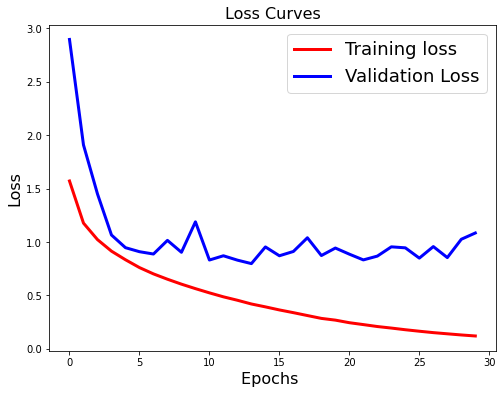

In [35]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

Text(0.5, 1.0, 'Accuracy Curves')

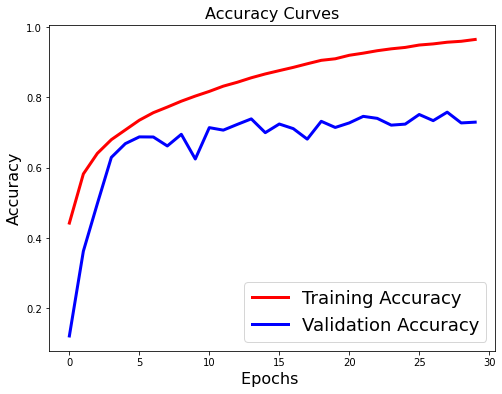

In [36]:
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)